In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Accumulation phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    capital = 10000
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

        if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
            capital += 0.99725 * (shares*price[i])
            shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
            previously_buy = False
            previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 2:
            capital += 0.99725 * (shares*price[i])
            shares = 0
#             print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') 
    logger.append(((capital- 10000 )/ 10000) * 100)
    
    capital = 10000
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') 
    logger.append(((capital- 10000 )/ 10000) * 100 )
    
    return logger

### Creating Training Data and Model

accumulation phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2001-01-08      22.3125  19.936626 -15.972222   192400.0     2.0
2001-01-09      20.5625  20.032914 -35.416667 -1320000.0     2.0
2001-01-10      20.7500  20.143235 -33.333333  -439800.0     2.0
2001-01-11      21.1250  20.294276 -29.166667   290200.0     2.0
2001-01-12      22.6875  20.662464 -13.178295  1360200.0     2.0


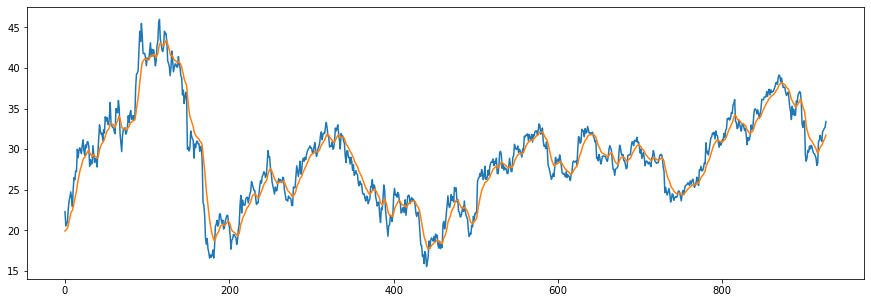

accumulation phase data\1_acc_data.csv
            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2013-10-21   122.519997  119.133586  -3.571469  268371800.0     2.0
2013-10-22   121.470001  119.493034 -14.600827  265163900.0     2.0
2013-10-23   122.480003  119.952568 -12.619492  269595100.0     2.0
2013-10-24   129.020004  121.347558  -5.825830  280361400.0     2.0
2013-10-25   128.979996  122.521779  -6.066121  275385200.0     2.0


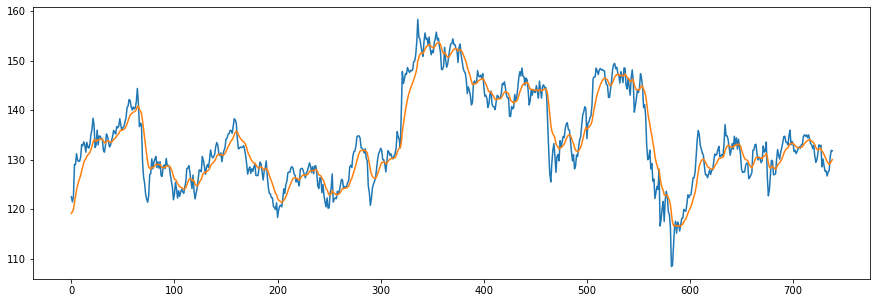

accumulation phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2011-06-02    16.940001  16.497632 -20.155042  9.557743e+09     2.0
2011-06-03    16.990000  16.573381 -24.475546  9.575374e+09     2.0
2011-06-07    17.440001  16.706707 -22.334963  9.601214e+09     2.0
2011-06-08    17.350000  16.805675 -26.903501  9.588997e+09     0.0
2011-06-09    17.760000  16.952494  -6.091318  9.611336e+09     2.0


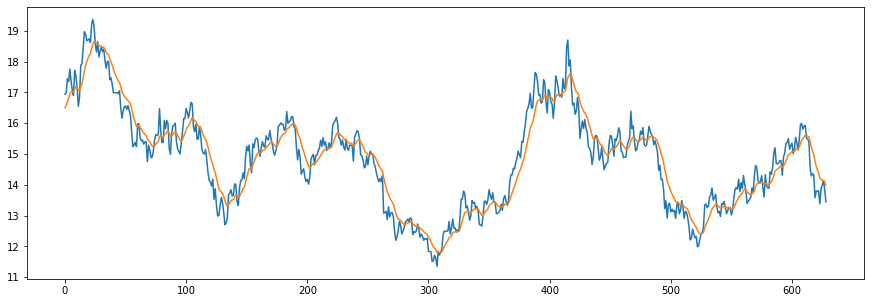

accumulation phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-08-30     6.405571  6.389804 -28.571449  273414472.0     2.0
2004-08-31     6.405571  6.392230 -28.571449  273414472.0     2.0
2004-09-01     6.454098  6.401748 -19.999921  278125245.0     2.0
2004-09-02     6.551152  6.424733  -0.000000  288787337.0     2.0
2004-09-03     6.599679  6.451648  -0.000000  306525894.0     2.0


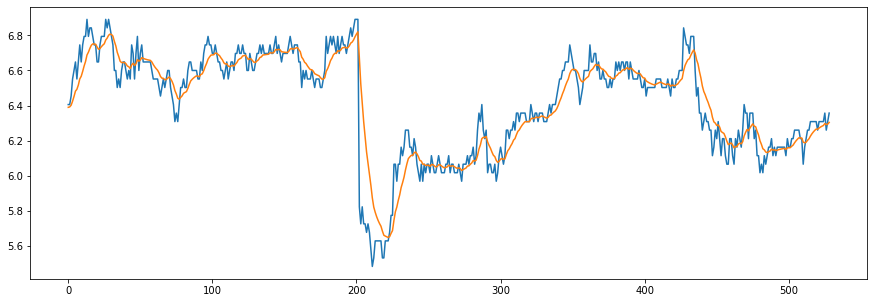

accumulation phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2009-08-03    38.650002  37.415266 -15.157111 -1.307058e+09     2.0
2009-08-04    39.599998  37.751379  -3.164588 -1.264100e+09     2.0
2009-08-05    40.209999  38.129628  -5.492443 -1.220737e+09     2.0
2009-08-06    41.779999  38.691224  -6.976777 -1.157402e+09     2.0
2009-08-07    40.750000  39.007958 -27.359985 -1.211578e+09     2.0


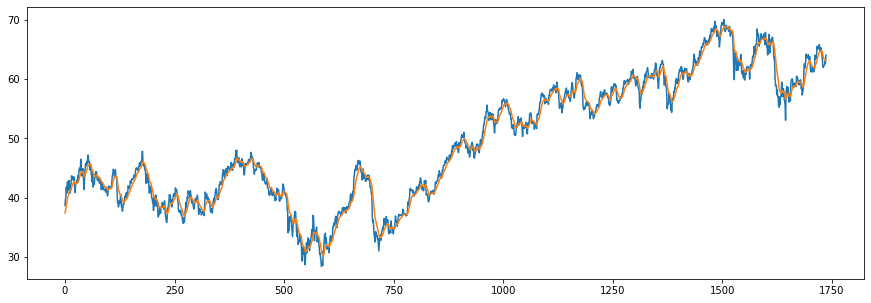

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('accumulation phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4491, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4491, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 4094, 0.0: 194, 1.0: 203})

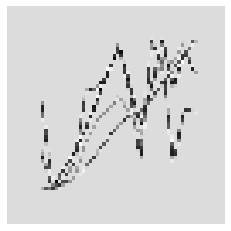

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.724731182795699, 1: 7.390946502057613, 2: 0.3655979643765903}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.3458 - accuracy: 0.6875 - mse: 5.5061 - weighted_accuracy: 0.4211 - weighted_mse: 5.3540WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 24ms/step - loss: 0.2359 - accuracy: 0.3126 - mse: 1.6574 - weighted_accuracy: 0.3634 - weighted_mse: 1.6263 - val_loss: 0.2246 - val_accuracy: 0.0423 - val_mse: 1.0181 - val_weighted_accuracy: 0.0423 - val_weighted_mse: 1.0181
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 0.2125 - accuracy: 0.1893 - mse: 1.2371 - weighted_accuracy: 0.3188 - weighted_mse: 1.2075 - val_loss: 0.2160 -

Test loss: 0.20646297931671143
Test accuracy: 0.08675798773765564


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 1
actual sells but predicted hold: 2
actual holds but predicted buy: 173
actual holds but predicted sell: 17
actual predicted holds: 11
Percentage buys correct: 3.723404255319149%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 84.61538461538461%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.593582887700535%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 76.92307692307692%




Capital at the end of test period: $10982.568117336265
profit gained: 9.825681173362645%


Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.104839      5.092593   

29/29 [==============================] - 0s 3ms/step - loss: 0.2066 - accuracy: 0.0992 - mse: 0.8912 - weighted_accuracy: 0.0992 - weighted_mse: 0.8912
Test loss: 0.20662401616573334
Test accuracy: 0.09923664480447769


number of predictions: 917
actual predicted buys: 46
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 30
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 731
actual holds but predicted sell: 63
actual predicted holds: 37
Percentage buys correct: 5.700123915737299%
Percentage sells correct: 11.267605633802816%
Percentage holds correct: 94.87179487179488%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 41.3151364764268%
Percentage high sells correct: 43.66197183098591%
Percentage mid holds correct: 94.87179487179488%




Capital at the end of test period: $3820.69496758959
profit gained: -61.793050324104094%


Capital at the end of test period i

29/29 [==============================] - 0s 9ms/step - loss: 0.1926 - accuracy: 0.2656 - mse: 1.1791 - weighted_accuracy: 0.4527 - weighted_mse: 1.1665 - val_loss: 0.1976 - val_accuracy: 0.1557 - val_mse: 0.9484 - val_weighted_accuracy: 0.1557 - val_weighted_mse: 0.9484
Validation loss: 0.19756342470645905
Validation accuracy: 0.15572859346866608


accumulation phase data


8/8 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.1371 - mse: 0.9521 - weighted_accuracy: 0.1371 - weighted_mse: 0.9521
Test loss: 0.19775158166885376
Test accuracy: 0.13709677755832672


number of predictions: 248
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 117
actual holds but predicted sell: 91
actual predicted holds: 21
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 3.1914893617021276%

19/19 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.1782 - mse: 0.9509 - weighted_accuracy: 0.1782 - weighted_mse: 0.9509
Test loss: 0.19740377366542816
Test accuracy: 0.17815126478672028


number of predictions: 595
actual predicted buys: 24
actual buys but predicted sell: 4
actual buys but predicted hold: 4
actual sells but predicted buy: 7
actual predicted sells: 18
actual sells but predicted hold: 2
actual holds but predicted buy: 265
actual holds but predicted sell: 207
actual predicted holds: 64
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 7.860262008733624%
Percentage holds correct: 91.42857142857143%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 48.813559322033896%
Percentage high sells correct: 50.21834061135371%
Percentage mid holds correct: 87.14285714285714%




Capital at the end of test period: $5459.2376911854535
profit gained: -45.40762308814546%


Capital at the end of test perio

29/29 [==============================] - 0s 10ms/step - loss: 0.1835 - accuracy: 0.2539 - mse: 1.2300 - weighted_accuracy: 0.5279 - weighted_mse: 1.2261 - val_loss: 0.1935 - val_accuracy: 0.1724 - val_mse: 1.0032 - val_weighted_accuracy: 0.1724 - val_weighted_mse: 1.0032
Epoch 13/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1828 - accuracy: 0.2712 - mse: 1.3054 - weighted_accuracy: 0.5261 - weighted_mse: 1.2812 - val_loss: 0.1971 - val_accuracy: 0.0934 - val_mse: 1.0297 - val_weighted_accuracy: 0.0934 - val_weighted_mse: 1.0297
Epoch 14/20
29/29 [==============================] - 0s 10ms/step - loss: 0.1839 - accuracy: 0.2734 - mse: 1.2613 - weighted_accuracy: 0.4978 - weighted_mse: 1.2483 - val_loss: 0.1980 - val_accuracy: 0.0912 - val_mse: 1.0638 - val_weighted_accuracy: 0.0912 - val_weighted_mse: 1.0638
Epoch 15/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1829 - accuracy: 0.2336 - mse: 1.2731 - weighted_accuracy: 0.5075 - weighted_mse: 1.2

7/7 [==============================] - 0s 2ms/step - loss: 0.1981 - accuracy: 0.1779 - mse: 1.1493 - weighted_accuracy: 0.1779 - weighted_mse: 1.1493
Test loss: 0.19807825982570648
Test accuracy: 0.17788460850715637


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 40
actual holds but predicted sell: 125
actual predicted holds: 24
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 5.970149253731344%
Percentage holds correct: 82.75862068965517%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.0%
Percentage high sells correct: 45.86466165413534%
Percentage mid holds correct: 72.41379310344827%




Capital at the end of test period: $11601.62235345458
profit gained: 16.016223534545805%


Capital at the end of test period if Buy and Hold: $1

29/29 [==============================] - 0s 9ms/step - loss: 0.1715 - accuracy: 0.2124 - mse: 1.3900 - weighted_accuracy: 0.5550 - weighted_mse: 1.3614 - val_loss: 0.2061 - val_accuracy: 0.1179 - val_mse: 1.1169 - val_weighted_accuracy: 0.1179 - val_weighted_mse: 1.1169
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1699 - accuracy: 0.2336 - mse: 1.4057 - weighted_accuracy: 0.5472 - weighted_mse: 1.3437 - val_loss: 0.2026 - val_accuracy: 0.1769 - val_mse: 1.2588 - val_weighted_accuracy: 0.1769 - val_weighted_mse: 1.2588
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1725 - accuracy: 0.1829 - mse: 1.3766 - weighted_accuracy: 0.5670 - weighted_mse: 1.3276 - val_loss: 0.2037 - val_accuracy: 0.1457 - val_mse: 1.3000 - val_weighted_accuracy: 0.1457 - val_weighted_mse: 1.3000
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1691 - accuracy: 0.2197 - mse: 1.3738 - weighted_accuracy: 0.5479 - weighted_mse: 1.3376 - 

2          -5.155469  


mark down phase data


9/9 [==============================] - 0s 2ms/step - loss: 0.1994 - accuracy: 0.2122 - mse: 1.1412 - weighted_accuracy: 0.2122 - weighted_mse: 1.1412
Test loss: 0.199391171336174
Test accuracy: 0.21223022043704987


number of predictions: 278
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 126
actual holds but predicted sell: 88
actual predicted holds: 35
Percentage buys correct: 9.79020979020979%
Percentage sells correct: 10.1010101010101%
Percentage holds correct: 97.22222222222223%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 46.478873239436616%
Percentage high sells correct: 53.535353535353536%
Percentage mid holds correct: 91.66666666666667%




Capital at the end of test period: $3475.490834281898
profit gained: -65.245091657

Epoch 1/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1555 - accuracy: 0.2539 - mse: 1.3897 - weighted_accuracy: 0.6410 - weighted_mse: 1.4181 - val_loss: 0.2064 - val_accuracy: 0.1457 - val_mse: 1.2926 - val_weighted_accuracy: 0.1457 - val_weighted_mse: 1.2926
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.2500 - mse: 1.4563 - weighted_accuracy: 0.6272 - weighted_mse: 1.4873 - val_loss: 0.1971 - val_accuracy: 0.2536 - val_mse: 1.2887 - val_weighted_accuracy: 0.2536 - val_weighted_mse: 1.2887
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1556 - accuracy: 0.2506 - mse: 1.4536 - weighted_accuracy: 0.6272 - weighted_mse: 1.4404 - val_loss: 0.2006 - val_accuracy: 0.2247 - val_mse: 1.2568 - val_weighted_accuracy: 0.2247 - val_weighted_mse: 1.2568
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1550 - accuracy: 0.2375 - mse: 1.4961 - weighted_accuracy: 0.6273 - weighted_ms

1          25.654903  


distribution phase data


15/15 [==============================] - 0s 2ms/step - loss: 0.1938 - accuracy: 0.2979 - mse: 1.4074 - weighted_accuracy: 0.2979 - weighted_mse: 1.4074
Test loss: 0.19383028149604797
Test accuracy: 0.2978723347187042


number of predictions: 470
actual predicted buys: 16
actual buys but predicted sell: 5
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 11
actual sells but predicted hold: 7
actual holds but predicted buy: 160
actual holds but predicted sell: 153
actual predicted holds: 113
Percentage buys correct: 8.98876404494382%
Percentage sells correct: 6.508875739644971%
Percentage holds correct: 91.869918699187%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 53.37078651685393%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 85.36585365853658%




Capital at the end of test period: $9337.829149425486
profit gained: -6.6217

number of predictions: 917
actual predicted buys: 26
actual buys but predicted sell: 7
actual buys but predicted hold: 13
actual sells but predicted buy: 4
actual predicted sells: 23
actual sells but predicted hold: 13
actual holds but predicted buy: 313
actual holds but predicted sell: 297
actual predicted holds: 221
Percentage buys correct: 7.580174927113703%
Percentage sells correct: 7.033639143730887%
Percentage holds correct: 89.47368421052632%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.66081871345029%
Percentage high sells correct: 50.15290519877676%
Percentage mid holds correct: 82.18623481781377%




Capital at the end of test period: $4477.880670467706
profit gained: -55.221193295322934%


Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.290323      8.988764       3.225806      92.424242   
1       0.324201 

8/8 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.4435 - mse: 1.4471 - weighted_accuracy: 0.4435 - weighted_mse: 1.4471
Test loss: 0.17685562372207642
Test accuracy: 0.44354838132858276


number of predictions: 248
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 67
actual holds but predicted sell: 63
actual predicted holds: 99
Percentage buys correct: 11.39240506329114%
Percentage sells correct: 3.076923076923077%
Percentage holds correct: 95.1923076923077%
actual buys: 11
actual sells: 8
actual holds: 229


Percentage low buys correct: 48.10126582278481%
Percentage high sells correct: 52.30769230769231%
Percentage mid holds correct: 87.37864077669903%




Capital at the end of test period: $10574.202649959552
profit gained: 5.742026499595522%


Capital at the end of test period if Buy a

19/19 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.4235 - mse: 1.4742 - weighted_accuracy: 0.4235 - weighted_mse: 1.4742
Test loss: 0.1797640323638916
Test accuracy: 0.42352941632270813


number of predictions: 595
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 16
actual sells but predicted buy: 5
actual predicted sells: 8
actual sells but predicted hold: 14
actual holds but predicted buy: 165
actual holds but predicted sell: 140
actual predicted holds: 231
Percentage buys correct: 7.103825136612022%
Percentage sells correct: 5.298013245033113%
Percentage holds correct: 88.50574712643679%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.81967213114754%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 81.99233716475096%




Capital at the end of test period: $6356.785164632757
profit gained: -36.432148353672424%


Capital at the end of test peri

29/29 [==============================] - 0s 9ms/step - loss: 0.1203 - accuracy: 0.4607 - mse: 1.8293 - weighted_accuracy: 0.7432 - weighted_mse: 2.2007 - val_loss: 0.1755 - val_accuracy: 0.4805 - val_mse: 1.6080 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 1.6080
Epoch 13/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1212 - accuracy: 0.4749 - mse: 1.7508 - weighted_accuracy: 0.7303 - weighted_mse: 2.1445 - val_loss: 0.1765 - val_accuracy: 0.4661 - val_mse: 1.7147 - val_weighted_accuracy: 0.4661 - val_weighted_mse: 1.7147
Epoch 14/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1213 - accuracy: 0.4638 - mse: 1.8164 - weighted_accuracy: 0.7242 - weighted_mse: 2.1668 - val_loss: 0.1758 - val_accuracy: 0.4661 - val_mse: 1.6499 - val_weighted_accuracy: 0.4661 - val_weighted_mse: 1.6499
Epoch 15/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1190 - accuracy: 0.4975 - mse: 1.8257 - weighted_accuracy: 0.7427 - weighted_mse: 2.2039

7/7 [==============================] - 0s 2ms/step - loss: 0.1625 - accuracy: 0.5625 - mse: 1.6412 - weighted_accuracy: 0.5625 - weighted_mse: 1.6412
Test loss: 0.16250906884670258
Test accuracy: 0.5625


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 31
actual holds but predicted sell: 50
actual predicted holds: 108
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.52542372881356%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 62.857142857142854%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 85.59322033898304%




Capital at the end of test period: $11487.527742797842
profit gained: 14.875277427978418%


Capital at the end of test period if Buy and Hold:

29/29 [==============================] - 0s 9ms/step - loss: 0.1139 - accuracy: 0.5175 - mse: 1.8950 - weighted_accuracy: 0.7519 - weighted_mse: 2.3711 - val_loss: 0.1631 - val_accuracy: 0.5628 - val_mse: 1.7172 - val_weighted_accuracy: 0.5628 - val_weighted_mse: 1.7172
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1144 - accuracy: 0.5161 - mse: 1.9202 - weighted_accuracy: 0.7521 - weighted_mse: 2.4324 - val_loss: 0.1596 - val_accuracy: 0.5884 - val_mse: 1.6885 - val_weighted_accuracy: 0.5884 - val_weighted_mse: 1.6885
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.5312 - mse: 1.9255 - weighted_accuracy: 0.7668 - weighted_mse: 2.4614 - val_loss: 0.1516 - val_accuracy: 0.6296 - val_mse: 1.6428 - val_weighted_accuracy: 0.6296 - val_weighted_mse: 1.6428
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1075 - accuracy: 0.5507 - mse: 1.8961 - weighted_accuracy: 0.7662 - weighted_mse: 2.4938 - 

9/9 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.6403 - mse: 1.7535 - weighted_accuracy: 0.6403 - weighted_mse: 1.7535
Test loss: 0.14899547398090363
Test accuracy: 0.6402877569198608


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 52
actual holds but predicted sell: 28
actual predicted holds: 169
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 89.8936170212766%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.067796610169495%
Percentage high sells correct: 64.51612903225806%
Percentage mid holds correct: 83.9572192513369%




Capital at the end of test period: $6078.933319410316
profit gained: -39.21066680589684%


Capital at the end of test period if Buy




RUNNING EPOCHS 160 - 180



Epoch 1/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1024 - accuracy: 0.6283 - mse: 2.0100 - weighted_accuracy: 0.7882 - weighted_mse: 2.8347 - val_loss: 0.1512 - val_accuracy: 0.6329 - val_mse: 1.8768 - val_weighted_accuracy: 0.6329 - val_weighted_mse: 1.8768
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1008 - accuracy: 0.6194 - mse: 2.1633 - weighted_accuracy: 0.7909 - weighted_mse: 3.0043 - val_loss: 0.1403 - val_accuracy: 0.6763 - val_mse: 1.7344 - val_weighted_accuracy: 0.6763 - val_weighted_mse: 1.7344
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1013 - accuracy: 0.6183 - mse: 2.1350 - weighted_accuracy: 0.7886 - weighted_mse: 2.9035 - val_loss: 0.1423 - val_accuracy: 0.6752 - val_mse: 1.6099 - val_weighted_accuracy: 0.6752 - val_weighted_mse: 1.6099
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0984 - accuracy: 0.6086 - mse: 2.1183 - weighted

1          25.654903  


distribution phase data


15/15 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.7191 - mse: 1.8732 - weighted_accuracy: 0.7191 - weighted_mse: 1.8732
Test loss: 0.13385961949825287
Test accuracy: 0.7191489338874817


number of predictions: 470
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 17
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 15
actual holds but predicted buy: 56
actual holds but predicted sell: 43
actual predicted holds: 327
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 91.08635097493037%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 53.225806451612904%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 86.0724233983287%




Capital at the end of test period: $11254.375514678946
profit gained: 12.54

number of predictions: 917
actual predicted buys: 7
actual buys but predicted sell: 6
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 12
actual sells but predicted hold: 27
actual holds but predicted buy: 99
actual holds but predicted sell: 99
actual predicted holds: 633
Percentage buys correct: 6.542056074766355%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 91.34199134199135%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 52.83018867924528%
Percentage high sells correct: 56.41025641025641%
Percentage mid holds correct: 84.99278499278499%




Capital at the end of test period: $5731.777210691072
profit gained: -42.682227893089284%


Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.770161     19.047619       0.000000      92.574257   
1       0.730594   

8/8 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.8105 - mse: 2.1149 - weighted_accuracy: 0.8105 - weighted_mse: 2.1149
Test loss: 0.1092168390750885
Test accuracy: 0.8104838728904724


number of predictions: 248
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 19
actual predicted holds: 199
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 0.0%
Percentage holds correct: 92.12962962962963%
actual buys: 11
actual sells: 8
actual holds: 229


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.87037037037037%




Capital at the end of test period: $11414.386512002935
profit gained: 14.14386512002935%


Capital at the end of test period if Buy and Hold: $10834.4334352684

19/19 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.7899 - mse: 2.1705 - weighted_accuracy: 0.7899 - weighted_mse: 2.1705
Test loss: 0.11887660622596741
Test accuracy: 0.7899159789085388


number of predictions: 595
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 28
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 22
actual holds but predicted buy: 31
actual holds but predicted sell: 43
actual predicted holds: 462
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 90.234375%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 61.702127659574465%
Percentage mid holds correct: 83.36594911937378%




Capital at the end of test period: $7414.912458964346
profit gained: -25.85087541035654%


Capital at the end of test period if Buy and

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0     3.586411
1     9.825681
2    -8.751993
3   -73.608048
4    59.490646
5   -55.270500
6   -61.793050
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


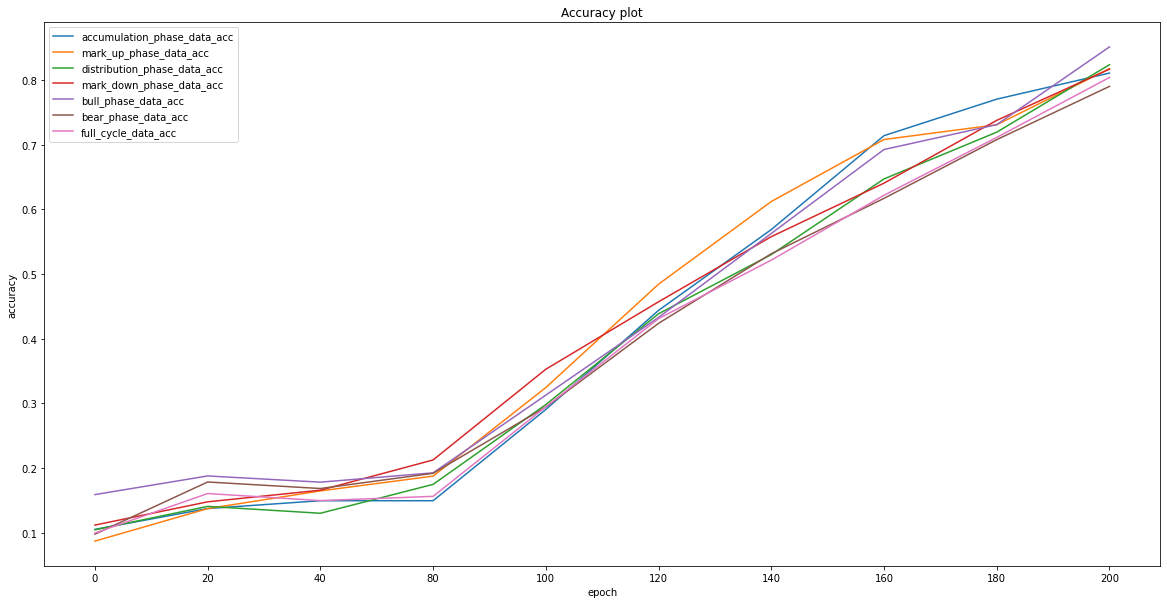

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

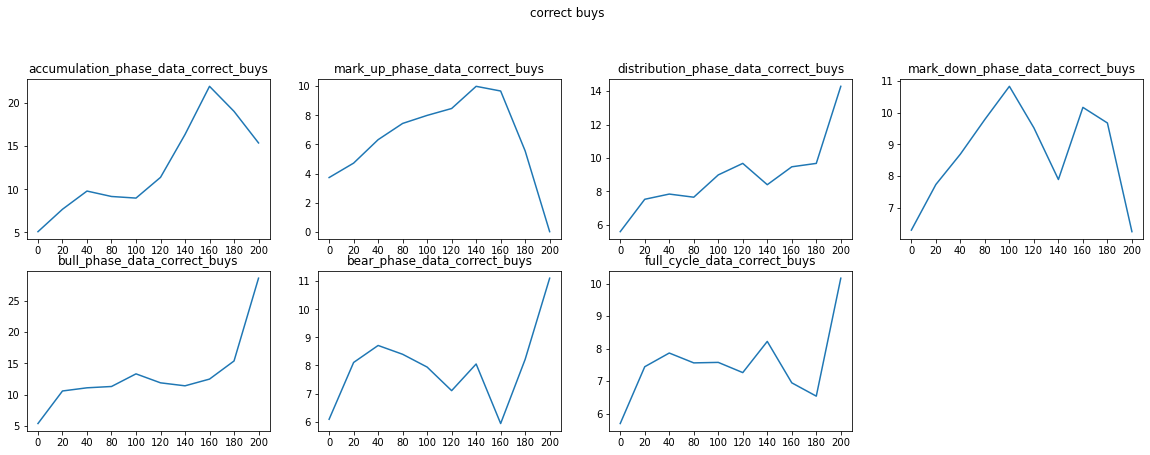

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

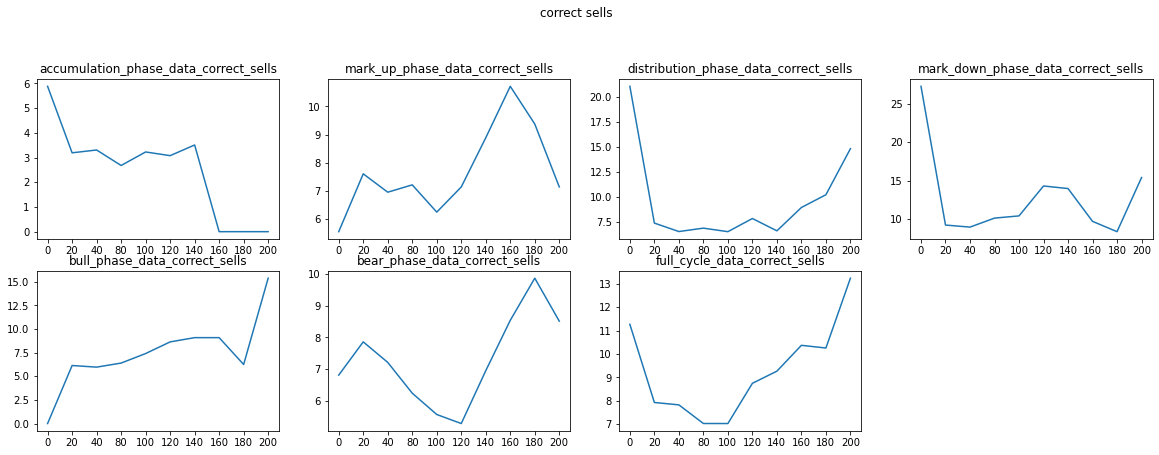

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

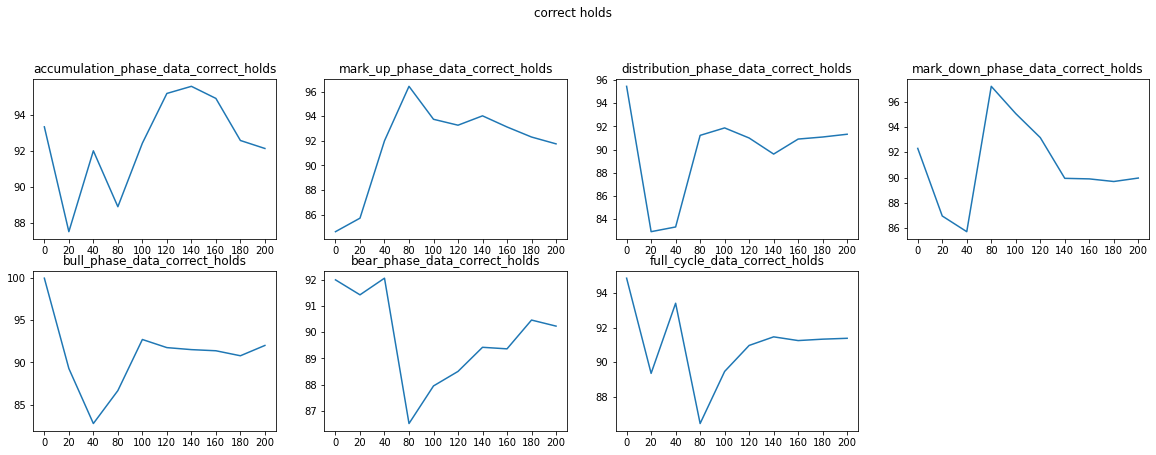

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

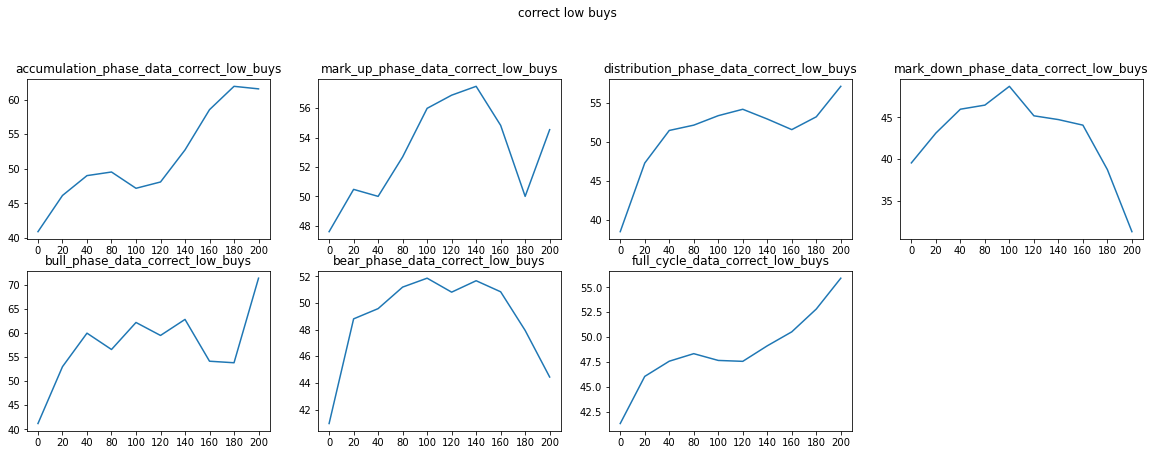

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

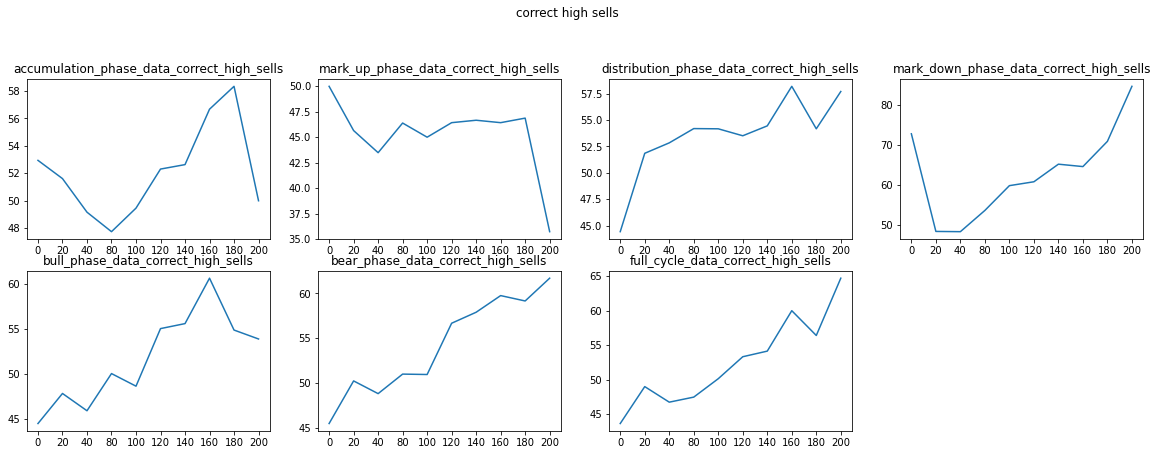

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

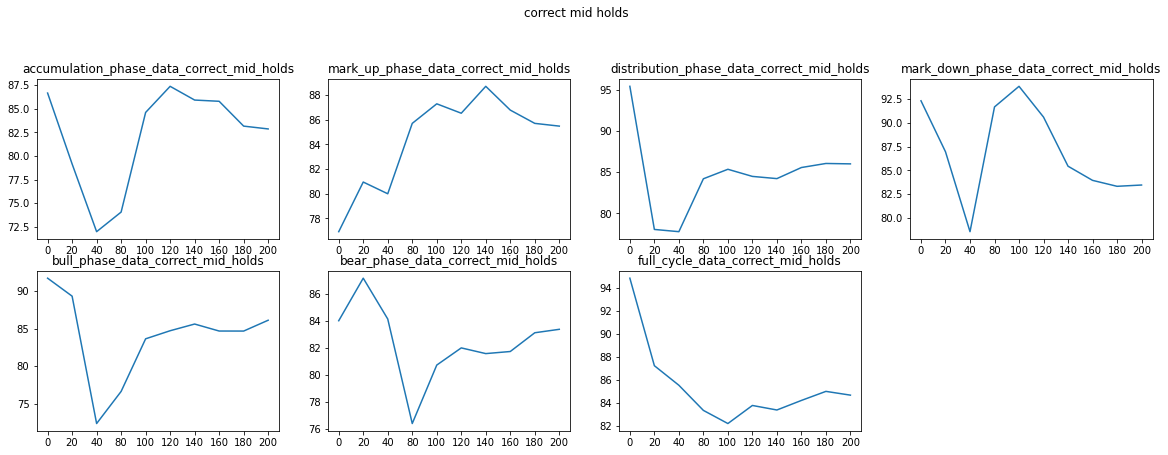

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

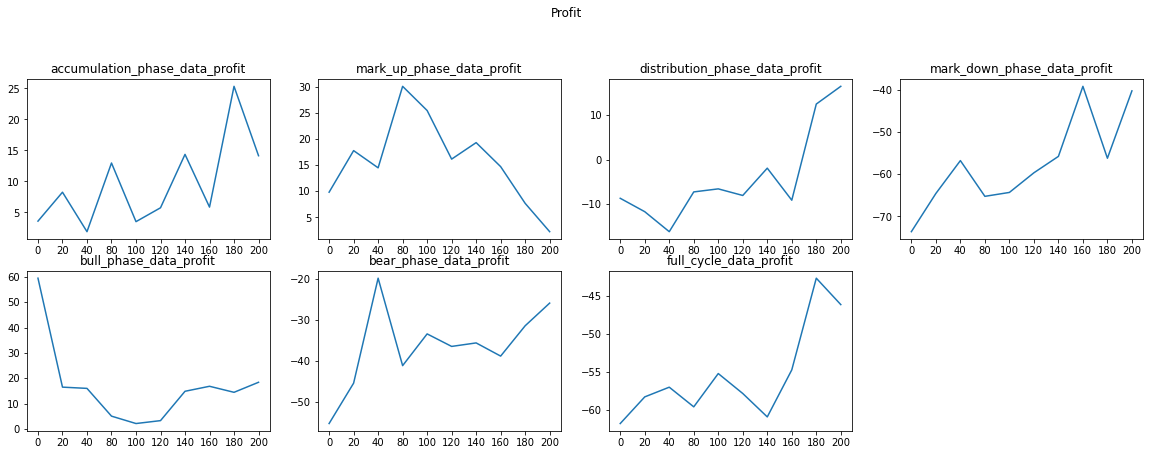

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")